## 温度预测示例

In [33]:
import os
fname = os.path.join('jena_climate_2009_2016.csv')

with open(fname) as f:
    data = f.read()
lines = data.split('\n')
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(header))
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
15
420451


In [3]:
# 转换为NumPy数组
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

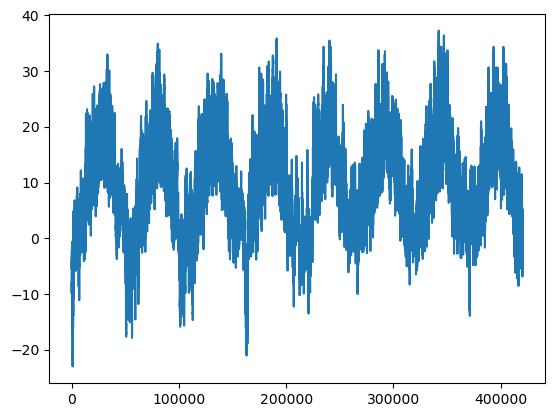

In [8]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

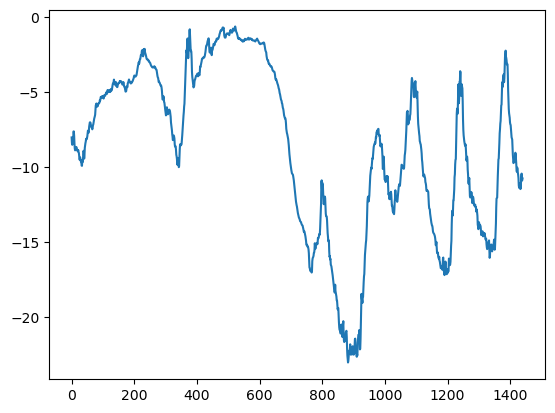

In [7]:
# 前10天的温度曲线
plt.plot(range(1440), temperature[:1440])

In [26]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2
)
for inputs, targets in dummy_dataset:
    print(f"batch_inputs_shape:{inputs.shape}")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


batch_inputs_shape:(2, 3)
[0, 1, 2] 3
[1, 2, 3] 4
batch_inputs_shape:(2, 3)
[2, 3, 4] 5
[3, 4, 5] 6
batch_inputs_shape:(1, 3)
[4, 5, 6] 7


In [30]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
# 数据规范化
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [31]:
# 采样频率是每小时一个数据点，每6个数据保留一个
sampling_rate = 6
# 观测序列：给定过去5天（120小时）
sequence_length = 120
# 目标序列：观测序列结束24消失后的温度
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)

In [32]:
for samples, targets in train_dataset:
    print(f"samples shape: {samples.shape}")
    print(f'targets shape: {targets.shape}')
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [36]:
# 建立基准：始终预测24小时之后的温度等于现在的温度
# 指标：平均绝对误差MAE, np.mean(np.abs(preds - targets))
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

tf.Tensor(
[ 3.64166307e-01  9.67291365e-01  1.71485522e-01 -1.53869895e+00
  4.73618113e-01 -7.31491881e-01 -8.58045532e-01  1.00719567e+00
  7.43827260e-01  2.00252303e+00  3.93809504e-01  2.56916416e+00
 -6.97288191e-01  1.03797899e+00  8.55559313e-01 -3.41569820e-01
 -1.53641871e+00 -8.43223933e-01  1.57725716e+00  1.20215670e+00
  7.09623571e-01  8.96603740e-01 -7.70612880e-02 -1.00626152e+00
  1.74827561e+00 -1.40074407e+00  8.44158083e-01 -1.05186644e+00
  1.90903295e+00 -1.81317111e-03  9.95794439e-01 -2.95329409e-03
  6.87961234e-01  1.52595163e+00 -2.00551388e-02  5.52286599e-01
  6.35515577e-01  4.49675530e-01 -7.79377046e-01  1.99568230e+00
 -5.53632695e-01 -4.24798798e-01  9.57030258e-01 -8.72867131e-01
 -1.18184046e+00 -2.60621088e-01  4.14331718e-01  3.23905184e-02
 -3.56391419e-01 -3.73493264e-01  7.17604431e-01 -7.56574586e-01
  9.15985831e-01  8.96603740e-01 -1.05414668e+00  1.65934602e+00
 -3.97435846e-01 -9.62936846e-01 -1.97764630e+00  5.83069919e-01
  1.18961535e+

In [44]:
# 全连接模型
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 flatten_3 (Flatten)         (None, 1680)              0         
                                                                 
 dense_6 (Dense)             (None, 16)                26896     
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [51]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras', save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 5s 5ms/step - loss: 5.9517 - mae: 1.9274 - val_loss: 11.2251 - val_mae: 2.6474
Epoch 2/10
819/819 [==============================] - 4s 5ms/step - loss: 5.8996 - mae: 1.9201 - val_loss: 12.1399 - val_mae: 2.7632
Epoch 3/10
819/819 [==============================] - 4s 5ms/step - loss: 5.8820 - mae: 1.9176 - val_loss: 12.0959 - val_mae: 2.7576
Epoch 4/10
819/819 [==============================] - 4s 5ms/step - loss: 5.8217 - mae: 1.9083 - val_loss: 11.1499 - val_mae: 2.6370
Epoch 5/10
819/819 [==============================] - 4s 5ms/step - loss: 5.7889 - mae: 1.9020 - val_loss: 12.7089 - val_mae: 2.8141
Epoch 6/10
819/819 [==============================] - 4s 5ms/step - loss: 5.7420 - mae: 1.8954 - val_loss: 11.2992 - val_mae: 2.6484
Epoch 7/10
819/819 [==============================] - 4s 5ms/step - loss: 5.7265 - mae: 1.8938 - val_loss: 11.6467 - val_mae: 2.7038
Epoch 8/10
819/819 [==============================] - 4s 5ms/step - l

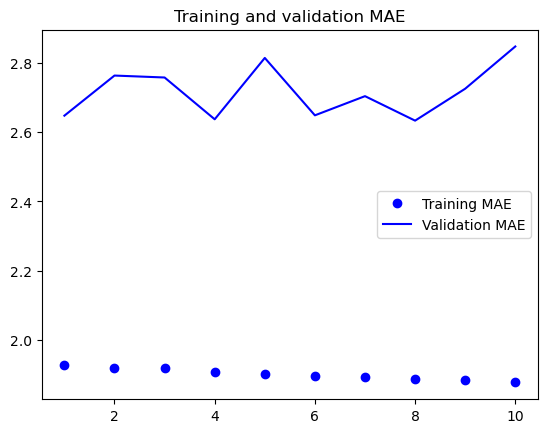

In [52]:
import matplotlib.pyplot as plt 
loss = history.history["mae"] 
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1) 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Training MAE") 
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE") 
plt.legend() 
plt.show()

In [53]:
model = keras.models.load_model('jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

405/405 [==============================] - 2s 4ms/step - loss: 12.3858 - mae: 2.7583
Test MAE: 2.76


In [56]:
# 一维CNN
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [     
    keras.callbacks.ModelCheckpoint("jena_conv.keras",                                     
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", 
              loss="mse", 
              metrics=["mae"])
history = model.fit(train_dataset,                     
                    epochs=10,                     
                    validation_data=val_dataset,                     
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 9s 6ms/step - loss: 22.1863 - mae: 3.6822 - val_loss: 15.2303 - val_mae: 3.0667
Epoch 2/10
819/819 [==============================] - 5s 6ms/step - loss: 15.4253 - mae: 3.1182 - val_loss: 18.4950 - val_mae: 3.4022
Epoch 3/10
819/819 [==============================] - 5s 6ms/step - loss: 14.3408 - mae: 2.9983 - val_loss: 14.2464 - val_mae: 2.9672
Epoch 4/10
819/819 [==============================] - 5s 6ms/step - loss: 13.5226 - mae: 2.9061 - val_loss: 14.8541 - val_mae: 3.0193
Epoch 5/10
819/819 [==============================] - 5s 6ms/step - loss: 12.9194 - mae: 2.8371 - val_loss: 14.5611 - val_mae: 3.0159
Epoch 6/10
819/819 [==============================] - 5s 6ms/step - loss: 12.4064 - mae: 2.7786 - val_loss: 13.6123 - val_mae: 2.9052
Epoch 7/10
819/819 [==============================] - 5s 6ms/step - loss: 11.9485 - mae: 2.7262 - val_loss: 15.4841 - val_mae: 3.1007
Epoch 8/10
819/819 [==============================] - 5s 6ms/s

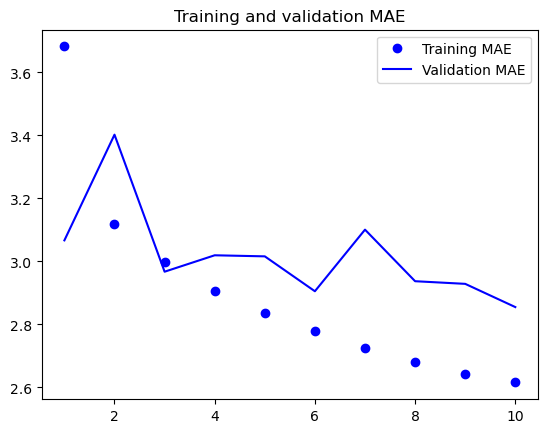

In [57]:
import matplotlib.pyplot as plt 
loss = history.history["mae"] 
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1) 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Training MAE") 
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE") 
plt.legend() 
plt.show()

In [59]:
# RNN
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [     
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",                                    
                                    save_best_only=True)] 
model.compile(optimizer="rmsprop", 
              loss="mse", 
              metrics=["mae"])
history = model.fit(train_dataset,                     
                    epochs=10,                     
                    validation_data=val_dataset,                     
                    callbacks=callbacks) 
model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 13s 11ms/step - loss: 41.7120 - mae: 4.7025 - val_loss: 12.4232 - val_mae: 2.6746
Epoch 2/10
819/819 [==============================] - 9s 10ms/step - loss: 11.0252 - mae: 2.5777 - val_loss: 9.7252 - val_mae: 2.4229
Epoch 3/10
819/819 [==============================] - 8s 10ms/step - loss: 9.8250 - mae: 2.4437 - val_loss: 9.7851 - val_mae: 2.4164
Epoch 4/10
819/819 [==============================] - 9s 10ms/step - loss: 9.2140 - mae: 2.3656 - val_loss: 9.6245 - val_mae: 2.3871
Epoch 5/10
819/819 [==============================] - 9s 10ms/step - loss: 8.7031 - mae: 2.3066 - val_loss: 9.5520 - val_mae: 2.3923
Epoch 6/10
819/819 [==============================] - 8s 10ms/step - loss: 8.3953 - mae: 2.2690 - val_loss: 9.7603 - val_mae: 2.4181
Epoch 7/10
819/819 [==============================] - 9s 10ms/step - loss: 8.1687 - mae: 2.2385 - val_loss: 9.7409 - val_mae: 2.4198
Epoch 8/10
819/819 [==============================] - 8s 10ms/ste

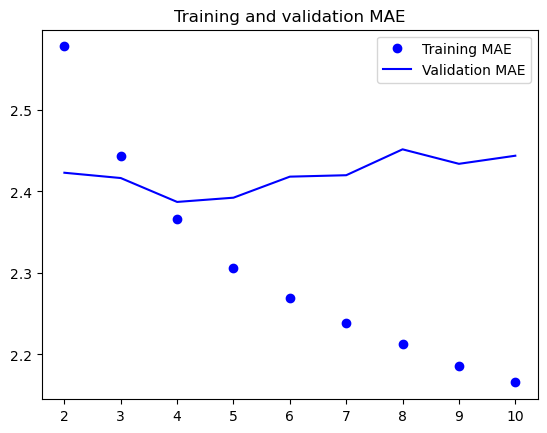

In [69]:
import matplotlib.pyplot as plt 
loss = history.history["mae"][1:]
val_loss = history.history["val_mae"][1:]
epochs = range(2, len(loss) + 2) 
plt.figure() 
plt.plot(epochs, loss, "bo", label="Training MAE") 
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE") 
plt.legend() 
plt.show()

## 理解RNN

In [ ]:
# 简单RNN的NumPy实现
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features, ))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
# 最终输出形状(timesteps, output_features)
final_output_sequence = np.stack(successive_outputs, axis=0)

In [73]:
# keras的RNN
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 16)
(None, 120, 16)


In [83]:
# 使用dropout正则化的LSTM模型
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                6016      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint('jena_lstm_dropout.keras',
                                    save_best_only=True)
]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
import tensorflow as tf
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

In [ ]:
# 使用dropout正则化的堆叠GRU模型
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [     
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",                                   
                                     save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,                     
                    epochs=50,                     
                    validation_data=val_dataset,                    
                    callbacks=callbacks)


In [88]:
# 双向LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 120, 14)]         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               3968      
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,001
Trainable params: 4,001
Non-trainable params: 0
_________________________________________________________________
